# __Ocean regimes indicator__

Apply a Gaussian Mixtures Model to a dataset of time series

***
ds : initial dataset (lat, lon, week)

X : staked dataset (sampling, week, week_reduced)

ds_labels: unstacked final dataset (lat, lon, week)
***

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl

import seaborn as sns
sns.set_context("paper")
with_seaborn = True

#import Plotter_2
#from Plotter_2 import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

from BIC_calculation_OR import *

## Load dataset
***

- One year of Ocean Color data in the Mediterranean Sea:  OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082 product

In [2]:
#file_path = 'datasets/dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep_1611225376956.nc' #in datarmor
file_path = 'datasets/dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep_1610026811620.nc'

Open dataset

In [3]:
ds = xr.open_dataset(file_path)
print(ds)
#ds

<xarray.Dataset>
Dimensions:    (lat: 385, lon: 1152, time: 365)
Coordinates:
  * time       (time) object 2019-01-01 00:00:00 ... 2019-12-31 00:00:00
  * lat        (lat) float32 46.020832 45.979164 45.9375 ... 30.062498 30.020832
  * lon        (lon) float32 -4.9791613 -4.9374948 ... 42.937508 42.97917
Data variables:
    CHL        (time, lat, lon) float32 ...
    CHL_error  (time, lat, lon) float32 ...
Attributes:
    comment:                      average
    distribution_statement:       See CMEMS Data License
    site_name:                    GLO
    parameter_code:               CHL
    creation_time:                16:39:54 UTC
    creation_date:                2020-11-05 UTC
    nb_grid_bins:                 37324800
    easternmost_longitude:        180.0
    references:                   http://www.globcolour.info GlobColour has b...
    registration:                 5
    stop_date:                    2020-07-01 UTC
    lon_step:                     0.041666668
    cmems_pr

In [4]:
ds['time'] = ds.indexes['time'].to_datetimeindex()
var_name = 'CHL'

__Quick plot__

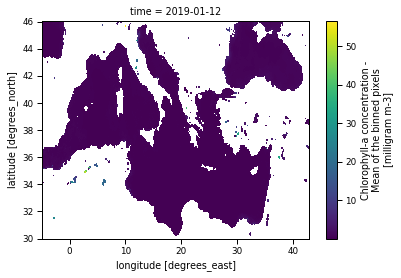

In [5]:
ds[var_name].isel(time=11).plot();

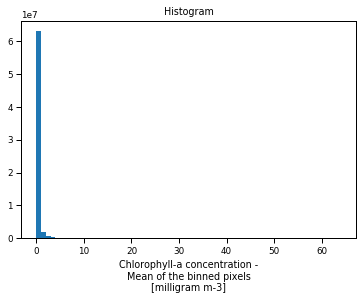

In [6]:
bins = np.arange(int(ds[var_name].min().values), int(ds[var_name].max().values))
ds[var_name].plot.hist(bins=bins);

## Preprocessing
***

#### __1) Weekly mean for each pixel__

In [7]:
ds = ds.groupby("time.week").mean()
#ds = ds.groupby("time.month").mean()
print(ds)
#ds

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/accessor_dt.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  field_values = getattr(values_as_series.dt, name).values
/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (lat: 385, lon: 1152, week: 52)
Coordinates:
  * lat        (lat) float32 46.020832 45.979164 45.9375 ... 30.062498 30.020832
  * lon        (lon) float32 -4.9791613 -4.9374948 ... 42.937508 42.97917
  * week       (week) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52
Data variables:
    CHL        (week, lat, lon) float32 0.2544443 0.25952786 ... nan nan
    CHL_error  (week, lat, lon) float32 32.89375 32.86875 32.69625 ... nan nan


Plot histogram in time

Text(0, 0.5, 'Counts')

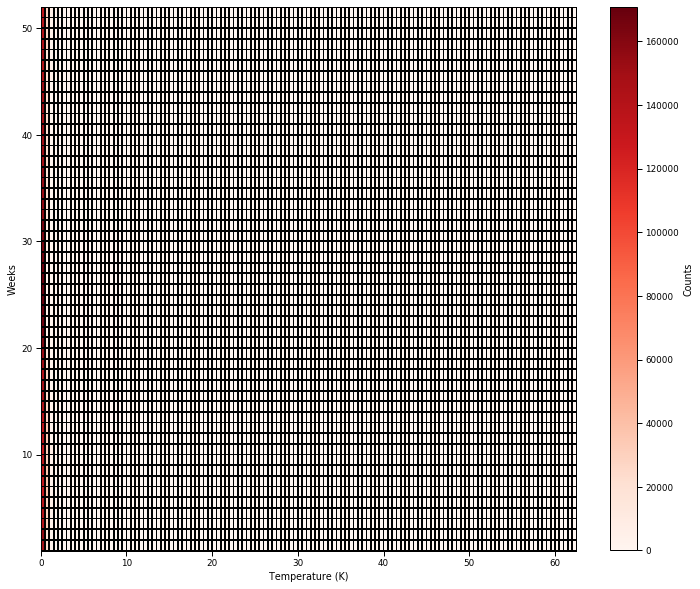

In [8]:
bins = np.arange(int(ds[var_name].min().values), int(ds[var_name].max().values),0.5)
#bins = np.arange(0, 0.3, 0.002)
histo_2d = [] 
for iweek in range(52):
#for iweek in range(12):
    hist_values, bin_edges = np.histogram(ds[var_name].isel(week=iweek).values, bins=bins)
    #hist_values, bin_edges = np.histogram(ds[var_name].isel(month=iweek).values, bins=bins)
    histo_2d.append(hist_values)
    
fig, ax = plt.subplots(figsize=(12,10))

#plt.pcolormesh(bins, ds.month.values, histo_2d, cmap='Reds', edgecolors='black')
plt.pcolormesh(bins, ds.week.values, histo_2d, cmap='Reds', edgecolors='black')
cbar = plt.colorbar()
ax.set_xlabel('Temperature (K)')
#ax.set_xlabel('Chlorophyll-a concentration (milligram m-3)')
ax.set_ylabel('Weeks')
cbar.ax.set_ylabel('Counts')

Try chlorophyll

Text(0, 0.5, 'Counts')

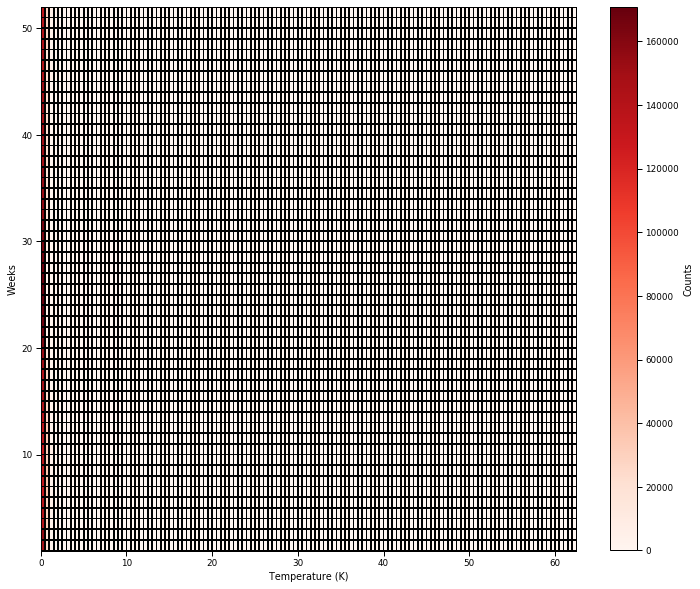

In [9]:
bins = np.arange(int(ds[var_name].min().values), int(ds[var_name].max().values),0.5)
#bins = np.arange(0, 0.3, 0.002)
histo_2d = [] 
for iweek in range(52):
#for iweek in range(12):
    hist_values, bin_edges = np.histogram(ds[var_name].isel(week=iweek).values, bins=bins)
    #hist_values, bin_edges = np.histogram(ds[var_name].isel(month=iweek).values, bins=bins)
    histo_2d.append(hist_values)
    
fig, ax = plt.subplots(figsize=(12,10))

#plt.pcolormesh(bins, ds.month.values, histo_2d, cmap='Reds', edgecolors='black')
plt.pcolormesh(bins, ds.week.values, histo_2d, cmap='Reds', edgecolors='black')
cbar = plt.colorbar()
ax.set_xlabel('Temperature (K)')
#ax.set_xlabel('Chlorophyll-a concentration (milligram m-3)')
ax.set_ylabel('Weeks')
cbar.ax.set_ylabel('Counts')

#### __2) Reduce lat lon dimensions to sampling dimension__

In [10]:
sampling_dims = list(ds.dims)
sampling_dims.remove('week')
#sampling_dims.remove('time')
sampling_dims

['lat', 'lon']

In [11]:
X = ds.stack({'sampling': sampling_dims})
X = X.rename_dims({'week': 'feature'})
X = X.rename({'week': 'feature'})
#X = X.rename_dims({'time': 'feature'})
#X = X.rename({'time': 'feature'})
print(X)
#X

<xarray.Dataset>
Dimensions:    (feature: 52, sampling: 443520)
Coordinates:
  * feature    (feature) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * sampling   (sampling) MultiIndex
  - lat        (sampling) float64 46.02 46.02 46.02 46.02 ... 30.02 30.02 30.02
  - lon        (sampling) float64 -4.979 -4.937 -4.896 ... 42.9 42.94 42.98
Data variables:
    CHL        (feature, sampling) float32 0.2544443 0.25952786 ... nan nan
    CHL_error  (feature, sampling) float32 32.89375 32.86875 ... nan nan


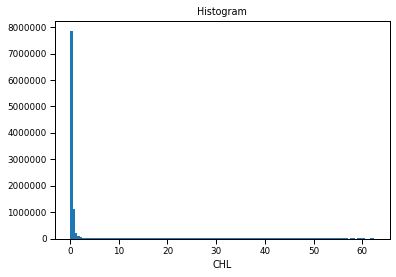

In [12]:
X[var_name].plot.hist(bins=bins);

#### __3) Delate all NaN time series using mask__

__Chlorophyll mask__: Create mask from another dataset

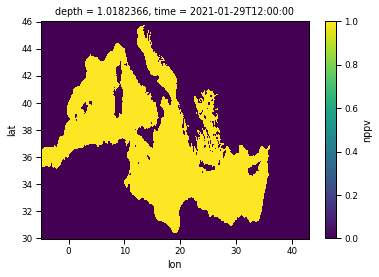

In [13]:
mask_file = 'datasets/med00-ogs-bio-an-fc-d_1611233647884.nc'
mask = xr.open_dataset(mask_file)
mask = mask.squeeze()
mask = mask.rename_dims({'latitude': 'lat', 'longitude':'lon'})
mask = mask.rename({'latitude': 'lat', 'longitude':'lon'})
mask = mask.interp_like(ds)
mask = mask['nppv'].notnull()
#print(ds)
mask.plot()

In [14]:
stacked_mask = mask.stack({'sampling': sampling_dims})
print(stacked_mask)
#stacked_mask

<xarray.DataArray 'nppv' (sampling: 443520)>
array([False, False, False, ..., False, False, False])
Coordinates:
    depth     float32 1.0182366
    time      datetime64[ns] 2021-01-29T12:00:00
  * sampling  (sampling) MultiIndex
  - lat       (sampling) float64 46.02 46.02 46.02 46.02 ... 30.02 30.02 30.02
  - lon       (sampling) float64 -4.979 -4.937 -4.896 ... 42.9 42.94 42.98


Apply mask

In [15]:
X = X[var_name].where(stacked_mask == True, drop=True).to_dataset()
print(X)
#X

<xarray.Dataset>
Dimensions:   (feature: 52, sampling: 140719)
Coordinates:
  * feature   (feature) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * sampling  (sampling) MultiIndex
  - lat       (sampling) float64 45.73 45.73 45.73 45.69 ... 30.35 30.35 30.35
  - lon       (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
    depth     float32 1.0182366
    time      datetime64[ns] 2021-01-29T12:00:00
Data variables:
    CHL       (feature, sampling) float32 4.440365 3.7976935 ... 0.250563


Delate time series that are all NaN, not taken in to acount in the mask

In [16]:
X = X[var_name].where(~X[var_name].isnull(),drop=True).to_dataset()

Recover the dataset (unravel)

In [17]:
X_unstacked = X[var_name].unstack('sampling').to_dataset(name = var_name)
X_unstacked = X_unstacked.sortby(['lat','lon'])
print(np.shape(X_unstacked[var_name]))
# same lat and lon values in mask and in results
mask = stacked_mask.unstack()
X_unstacked = X_unstacked.reindex_like(mask)
print(np.shape(X_unstacked[var_name]))
print(X_unstacked) 

(52, 370, 988)
(52, 385, 1152)
<xarray.Dataset>
Dimensions:  (feature: 52, lat: 385, lon: 1152)
Coordinates:
  * lat      (lat) float64 46.02 45.98 45.94 45.9 ... 30.15 30.1 30.06 30.02
  * lon      (lon) float64 -4.979 -4.937 -4.896 -4.854 ... 42.9 42.94 42.98
  * feature  (feature) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52
    depth    float32 1.0182366
    time     datetime64[ns] 2021-01-29T12:00:00
Data variables:
    CHL      (feature, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan


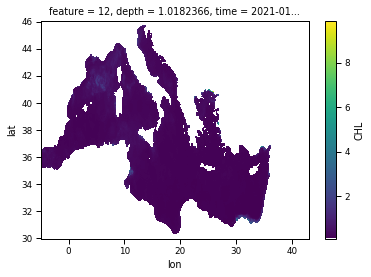

In [18]:
X_unstacked[var_name].isel(feature=11).plot();

__There is any NaN in the dataset?__

In [19]:
#np.any(np.isnan(X[var_name].values))
np.sum(np.isnan(X[var_name].values))

#np.argwhere(np.isnan(X[var_name].values))

48

#### __4) Interpolation__

Not necessary if using mask created from dataset

In [20]:
#X = X[var_name].interpolate_na(dim = 'feature', method="linear", fill_value="extrapolate").to_dataset(name = var_name)
X = X[var_name].interpolate_na(dim = 'feature', method="linear", fill_value="extrapolate").to_dataset(name = var_name)
print(X)
#X

<xarray.Dataset>
Dimensions:   (feature: 52, sampling: 140700)
Coordinates:
  * feature   (feature) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * sampling  (sampling) MultiIndex
  - lat       (sampling) float64 45.73 45.73 45.73 45.69 ... 30.35 30.35 30.35
  - lon       (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
    depth     float32 1.0182366
    time      datetime64[ns] 2021-01-29T12:00:00
Data variables:
    CHL       (feature, sampling) float32 4.440365 3.7976935 ... 0.250563


__There is any NaN in the dataset?__

In [21]:
#np.any(np.isnan(X[var_name].values))
np.sum(np.isnan(X[var_name].values))

0

#### __5) Scaler__

choose the best scaler: https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer

__Check dimensions order__
***

In [22]:
np.shape(X[var_name])

(52, 140700)

Transpose dataset if needed (sampling x features)

In [23]:
X = X.transpose("sampling", "feature")
np.shape(X[var_name].values)

(140700, 52)

***

Apply sklearn __StandardScaler__: 
Standardize features by removing the mean and scaling to unit variance
The standard score of a sample x is calculated as:

    z = (x - u) / s
    
where u is the mean of the training samples or zero if `with_mean=False`, and s is the standard deviation of the training samples or one if `with_std=False`.
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. 

shape (n_samples, n_features), calculate mean for each feature

In [24]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler().fit_transform(X[var_name])
X = X.assign(variables={var_name + "_scaled":(('sampling', 'feature'), X_scale)})
#X = X.assign(variables={var_name + "_scaled":(('feature', 'sampling'), X_scale)})
print(X)
#X

<xarray.Dataset>
Dimensions:     (feature: 52, sampling: 140700)
Coordinates:
  * feature     (feature) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * sampling    (sampling) MultiIndex
  - lat         (sampling) float64 45.73 45.73 45.73 45.69 ... 30.35 30.35 30.35
  - lon         (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
    depth       float32 1.0182366
    time        datetime64[ns] 2021-01-29T12:00:00
Data variables:
    CHL         (sampling, feature) float32 4.440365 2.17191 ... 0.250563
    CHL_scaled  (sampling, feature) float32 18.874125 8.942784 ... -0.22905086


In [25]:
print(X_scale.min())
print(X_scale.max())

-0.9744167
74.68402


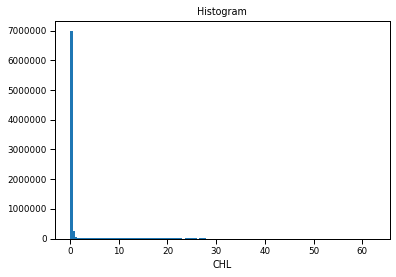

In [26]:
X[var_name].plot.hist(bins=bins);

__Normalizer__ : shape (n_samples, n_features), calculate mean for each sample

In [27]:
#from sklearn.preprocessing import Normalizer
#X_scale = Normalizer().fit_transform(X[var_name])
#X = X.assign(variables={var_name + "_scaled":(('sampling', 'feature'), X_scale)})

In [28]:
#print(X_scale.min())
#print(X_scale.max())

In [29]:
#X[var_name].plot.hist(bins=bins);

__MinMaxScaler__: scale each feature. shape (n_samples, n_features)

In [30]:
#from sklearn.preprocessing import MinMaxScaler
#X_scale = MinMaxScaler().fit_transform(X[var_name])
#X = X.assign(variables={var_name + "_scaled":(('sampling', 'feature'), X_scale)})

In [31]:
#print(X_scale.min())
#print(X_scale.max())

In [32]:
#print(X[var_name].min().values)
#print(X[var_name].max().values)

In [33]:
#X[var_name].plot.hist(bins=bins);

#### __5) PCA__

Apply __Principal component analysis__ (PCA):
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
If `0 < n_components < 1` and `svd_solver == 'full'`, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99, svd_solver = 'full')
pca

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [35]:
pca = pca.fit(X[var_name + "_scaled"])

Text(0.5, 1.0, 'Percentage of variance explained by each of the selected components')

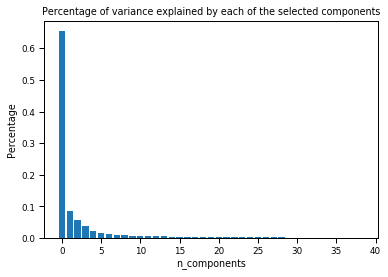

In [36]:
fig, ax = plt.subplots()
pb = plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
ax.set_xlabel('n_components')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of variance explained by each of the selected components')

In [37]:
X_reduced = pca.transform(X[var_name + "_scaled"])
np.shape(X_reduced)

(140700, 39)

In [38]:
X = X.assign(variables={var_name + "_reduced":(('sampling', 'feature_reduced'),X_reduced)})
print(X)

<xarray.Dataset>
Dimensions:      (feature: 52, feature_reduced: 39, sampling: 140700)
Coordinates:
  * feature      (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lat          (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon          (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
    depth        float32 1.0182366
    time         datetime64[ns] 2021-01-29T12:00:00
Dimensions without coordinates: feature_reduced
Data variables:
    CHL          (sampling, feature) float32 4.440365 2.17191 ... 0.250563
    CHL_scaled   (sampling, feature) float32 18.874125 8.942784 ... -0.22905086
    CHL_reduced  (sampling, feature_reduced) float32 65.005486 ... 0.15470983


## Apply Model
***

__Create model__

In [39]:
from sklearn import mixture
k = 7 # number of classes
model = mixture.GaussianMixture(n_components=k, covariance_type='full')
model

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [40]:
#from sklearn.cluster import KMeans
#k=7
#model = KMeans(n_clusters=7)
#model

__Fit model__

In [41]:
model.fit(X[var_name + "_reduced"])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

__Predict labels__

In [42]:
X_labels = model.predict(X[var_name + "_reduced"])
X_labels

array([2, 2, 2, ..., 3, 3, 3])

In [43]:
print(X_labels.min())
print(X_labels.max())

0
6


In [44]:
X = X.assign(variables={"GMM_labels":(('sampling'),X_labels)})
print(X)
#X

<xarray.Dataset>
Dimensions:      (feature: 52, feature_reduced: 39, sampling: 140700)
Coordinates:
  * feature      (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lat          (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon          (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
    depth        float32 1.0182366
    time         datetime64[ns] 2021-01-29T12:00:00
Dimensions without coordinates: feature_reduced
Data variables:
    CHL          (sampling, feature) float32 4.440365 2.17191 ... 0.250563
    CHL_scaled   (sampling, feature) float32 18.874125 8.942784 ... -0.22905086
    CHL_reduced  (sampling, feature_reduced) float32 65.005486 ... 0.15470983
    GMM_labels   (sampling) int64 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3


Calculate other __stadistics__

- Predict posterior probability of each component given the data

In [45]:
X_proba = model.predict_proba(X[var_name + "_reduced"])
np.shape(X_proba)

(140700, 7)

In [46]:
X = X.assign(variables={"GMM_post":(('sampling','k'),X_proba)})
print(X)
#X

<xarray.Dataset>
Dimensions:      (feature: 52, feature_reduced: 39, k: 7, sampling: 140700)
Coordinates:
  * feature      (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lat          (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon          (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
    depth        float32 1.0182366
    time         datetime64[ns] 2021-01-29T12:00:00
Dimensions without coordinates: feature_reduced, k
Data variables:
    CHL          (sampling, feature) float32 4.440365 2.17191 ... 0.250563
    CHL_scaled   (sampling, feature) float32 18.874125 8.942784 ... -0.22905086
    CHL_reduced  (sampling, feature_reduced) float32 65.005486 ... 0.15470983
    GMM_labels   (sampling) int64 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3
    GMM_post     (sampling, k) float64 0.0 3.755e-322 ... 2.682e-11 2.428e-60


- Calculate quantiles

In [47]:
#quantiles we want to calculate
q = [0.05, 0.5, 0.95]

In [48]:
m_quantiles = X[var_name].where(X['GMM_labels']==0, drop=True).quantile(q, dim='sampling')
for yi in range(1,k):
    m_quantiles = xr.concat((m_quantiles, X[var_name].where(X['GMM_labels']==yi, drop=True).quantile(q, dim='sampling')), dim='k')

In [49]:
X = X.assign(variables={var_name + "_Q":(('k','quantiles','feature'), m_quantiles)})
print(X)

<xarray.Dataset>
Dimensions:      (feature: 52, feature_reduced: 39, k: 7, quantiles: 3, sampling: 140700)
Coordinates:
  * feature      (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lat          (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon          (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
    depth        float32 1.0182366
    time         datetime64[ns] 2021-01-29T12:00:00
Dimensions without coordinates: feature_reduced, k, quantiles
Data variables:
    CHL          (sampling, feature) float32 4.440365 2.17191 ... 0.250563
    CHL_scaled   (sampling, feature) float32 18.874125 8.942784 ... -0.22905086
    CHL_reduced  (sampling, feature_reduced) float32 65.005486 ... 0.15470983
    GMM_labels   (sampling) int64 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3
    GMM_post     (sampling, k) float64 0.0 3.755e-322 ... 2.682e-11 2.428e-60
    CHL_Q        (k, quantiles, feature) float64 

- Calculate quantiles scaled variable

In [50]:
#quantiles we want to calculate
q = [0.05, 0.5, 0.95]

In [51]:
m_quantiles = X[var_name].where(X['GMM_labels']==0, drop=True).quantile(q, dim='sampling')
for yi in range(1,k):
    m_quantiles = xr.concat((m_quantiles, X[var_name + '_scaled'].where(X['GMM_labels']==yi, drop=True).quantile(q, dim='sampling')), dim='k')

In [52]:
X = X.assign(variables={var_name + '_scaled'+ "_Q":(('k','quantiles','feature'), m_quantiles)})
print(X)

<xarray.Dataset>
Dimensions:       (feature: 52, feature_reduced: 39, k: 7, quantiles: 3, sampling: 140700)
Coordinates:
  * feature       (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon           (sampling) float64 13.56 13.6 13.65 ... 19.23 19.27 19.31
    depth         float32 1.0182366
    time          datetime64[ns] 2021-01-29T12:00:00
Dimensions without coordinates: feature_reduced, k, quantiles
Data variables:
    CHL           (sampling, feature) float32 4.440365 2.17191 ... 0.250563
    CHL_scaled    (sampling, feature) float32 18.874125 8.942784 ... -0.22905086
    CHL_reduced   (sampling, feature_reduced) float32 65.005486 ... 0.15470983
    GMM_labels    (sampling) int64 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3
    GMM_post      (sampling, k) float64 0.0 3.755e-322 ... 2.682e-11 2.428e-60
    CHL_Q         (k, quantiles, feature) f

- Calculate robustness

In [53]:
maxpost = X["GMM_post"].max(dim="k")
K = len(X["GMM_labels"])
robust = (maxpost - 1. / K) * K / (K - 1.)

Plist = [0, 0.33, 0.66, 0.9, .99, 1]
rowl0 = ('Unlikely', 'As likely as not', 'Likely', 'Very Likely', 'Virtually certain')
robust_id = np.digitize(robust, Plist) - 1

In [54]:
X = X.assign(variables={"GMM_robustness":(('sampling'), robust), "GMM_robustness_cat":(('sampling'), robust_id)})
X["GMM_robustness_cat"].attrs['legend'] = rowl0
print(X)
#X

<xarray.Dataset>
Dimensions:             (feature: 52, feature_reduced: 39, k: 7, quantiles: 3, sampling: 140700)
Coordinates:
  * feature             (feature) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
  * sampling            (sampling) MultiIndex
  - lat                 (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35
  - lon                 (sampling) float64 13.56 13.6 13.65 ... 19.27 19.31
    depth               float32 1.0182366
    time                datetime64[ns] 2021-01-29T12:00:00
Dimensions without coordinates: feature_reduced, k, quantiles
Data variables:
    CHL                 (sampling, feature) float32 4.440365 ... 0.250563
    CHL_scaled          (sampling, feature) float32 18.874125 ... -0.22905086
    CHL_reduced         (sampling, feature_reduced) float32 65.005486 ... 0.15470983
    GMM_labels          (sampling) int64 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3
    GMM_post            (sampling, k) float64 0.0 3.755e-322 ... 2.428e-60
    CHL_Q            

__Unstack dataset__

In [55]:
ds_labels = X.unstack('sampling')
#ds_labels = ds_labels.sortby(['lat','lon'])
# same lat and lon values in mask and in results
mask = stacked_mask.unstack()
ds_labels = ds_labels.reindex_like(mask)
print(ds_labels)
#ds_labels

<xarray.Dataset>
Dimensions:             (feature: 52, feature_reduced: 39, k: 7, lat: 385, lon: 1152, quantiles: 3)
Coordinates:
  * lat                 (lat) float64 46.02 45.98 45.94 ... 30.1 30.06 30.02
  * lon                 (lon) float64 -4.979 -4.937 -4.896 ... 42.9 42.94 42.98
  * feature             (feature) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
    depth               float32 1.0182366
    time                datetime64[ns] 2021-01-29T12:00:00
Dimensions without coordinates: feature_reduced, k, quantiles
Data variables:
    CHL                 (feature, lat, lon) float32 nan nan nan ... nan nan nan
    CHL_scaled          (feature, lat, lon) float32 nan nan nan ... nan nan nan
    CHL_reduced         (feature_reduced, lat, lon) float32 nan nan ... nan nan
    GMM_labels          (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    GMM_post            (k, lat, lon) float64 nan nan nan nan ... nan nan nan
    CHL_Q               (k, quantiles, feature) float64 

In [56]:
ds_labels['CHL_reduced'].coords

Coordinates:
  * lat      (lat) float64 46.02 45.98 45.94 45.9 ... 30.15 30.1 30.06 30.02
  * lon      (lon) float64 -4.979 -4.937 -4.896 -4.854 ... 42.9 42.94 42.98
    depth    float32 1.0182366
    time     datetime64[ns] 2021-01-29T12:00:00

In [57]:
var_name + '_reduced'

'CHL_reduced'

## Preprocesing plots
***

__Scatter plot__

     feature_reduced_0  feature_reduced_1  labels
0             1.739263           0.061998     6.0
1            -1.931231           0.706862     2.0
2            -1.659998           1.164109     5.0
3            -0.036699           0.264292     6.0
4            -0.158124           0.080227     3.0
..                 ...                ...     ...
995          -1.691846           0.911492     0.0
996           3.198881          -3.132807     6.0
997          -0.482092           0.336192     3.0
998           0.560394           0.440789     6.0
999          -2.031446           0.762710     5.0

[1000 rows x 3 columns]


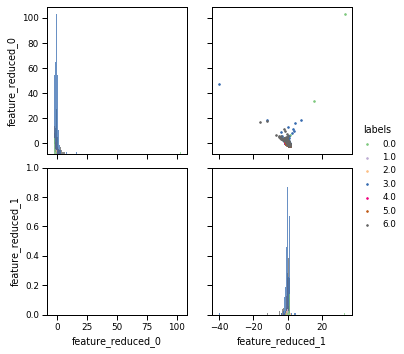

In [58]:
import Plotter_OR
from Plotter_OR import Plotter_OR 
P = Plotter_OR(ds_labels, model, coords_dict={'latitude':'lat', 'longitude':'lon', 'feature': 'feature'})
P.scatter_PDF(var_name = var_name + '_reduced')

In [ ]:
#convert colormap to pallete
import matplotlib.cm
cmap=plt.cm.get_cmap('Spectral', k)
matplotlib.cm.register_cmap("mycolormap", cmap)
cpal = sns.color_palette("mycolormap", n_colors=k)

In [ ]:
#convert to dataframe
ds_p = ds_labels['CHL_reduced']
ds_p = ds_p.drop_vars({'depth','time'})
df = ds_p.to_dataframe(name='CHL_reduced').unstack(0)
#select first and second components
df = df.take([0, 1], axis=1)
#add labels
df['labels'] = ds_labels['GMM_labels'].stack({'sampling': sampling_dims})
# do not use NaNs
df = df.dropna()

# random selection of points to make clear plots
n=1000
random_rows = np.random.choice(range(df.shape[0]), np.min((n, df.shape[0])), replace=False)
df = df.iloc[random_rows]
#format to simple dataframe
df = df.reset_index(drop=True)
df.columns = df.columns.droplevel(0)
df = df.rename_axis(None, axis=1)
df = df.rename(columns={0: "feature_reduced_0", 1: "feature_reduced_1", '': "labels"})

#defaults = {'height':2.5, 'aspect':1, 'hue':'labels', 'palette': m.plot.cmap(palette=True),
#                    'vars':m._xlabel, 'despine':False}
defaults = {'height':2.5, 'aspect':1, 'hue':'labels', 'despine':False, 'palette': cpal}
#defaults = {'height':2.5, 'aspect':1, 'despine':False, 'palette': cpal}
g = sns.PairGrid(df, **defaults)

g.map_diag(sns.histplot, edgecolor=None, alpha=0.75)
g = g.map_upper(plt.scatter, s=3)

g.add_legend()

In [ ]:
ds_p.dims
ds_p.coords.keys()

__BIC__

In [ ]:
corr_dist = 50 # correlation distance in km
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

In [ ]:
BIC, BIC_min = BIC_calculation(X=X, coords_dict={'latitude':'lat', 'longitude':'lon'}, 
                               corr_dist=corr_dist,
                               feature_name='feature_reduced', var_name= 'CHL_reduced',
                               Nrun=Nrun, NK=NK)

In [ ]:
plot_BIC(BIC, NK=NK)

## Plot results
***

In [ ]:
P = Plotter(ds)

#### __1) Quantiles time series__

Median and other quantiles representation

In [ ]:
plot_var= 'CHL_scaled'
line_style = ['--','-','--']
start_month = 7
cmap=plt.cm.get_cmap('Accent', k)
fig, ax = plt.subplots(nrows=k, ncols=1, figsize=(10,16))

#ticks in months
dates = 2019*1000 + ds_labels.feature*10 + 0
dates = dates.astype(str)
dates = pd.to_datetime(dates.values, format='%Y%W%w')

xaxis_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May',
                            'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
if start_month != 0:
    #reorder x values
    start_index = np.where(dates.month == 7)[0][0]
    new_order_index = np.concatenate(
            (np.arange(start_index, np.shape(dates)), np.arange(0, start_index)))
    x_values = pd.to_datetime([dates[i] for i in new_order_index])
    #reorder xlabels
    new_order = np.concatenate(
            (np.arange(start_month, 13), np.arange(1, start_month)))
    xaxis_labels = [xaxis_labels[i-1] for i in new_order]
    
index_ticks = np.unique(x_values.month, return_index=True)
index_ticks = np.sort(index_ticks[1])

for ik in range(k):
    ax[ik].grid()
    for iq in range(np.size(q)):
        
        y_values = ds_labels[plot_var + "_Q"].isel(quantiles=iq, k=ik)
        if start_month != 0:
            y_values = y_values.reindex({'feature': new_order_index+1})
            
        ax[ik].plot(y_values , line_style[iq], color=cmap(ik),  label = 'q = '+ str(q[iq]), linewidth=2)
        
    #ax[ik].set_xlabel('Weeks')
    ax[ik].set_xticks(index_ticks)
    ax[ik].set_xticklabels(xaxis_labels)
    ax[ik].set_ylabel('Chlorophyll-a (mg/m3)')
    ax[ik].set_title(("k = %i") % (ik), color=cmap(ik), fontweight="bold")
    ax[ik].legend(loc='upper right')

plt.subplots_adjust(hspace=0.4)

All median time series in the same plot 

In [ ]:
#quantile tou want to plot
plot_q = 0.5
plot_qi = q.index(plot_q)

cmap=plt.cm.get_cmap('Spectral', k)
fig = plt.figure(figsize=(20,6))
plt.grid()
for ik in range(k):
    plt.plot(ds_labels[var_name + "_Q"].isel(quantiles=plot_qi, k=ik),color=cmap(ik))

norm = mpl.colors.Normalize(vmin=0,vmax=k-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=range(k)) 
cbar.set_label('Classes', fontsize=12)
plt.gca().set_xlabel('Weeks')
plt.gca().set_ylabel('Temperature (K)')
plt.gca().set_title("Median time series (q=0.5)", fontsize=12, fontweight='bold')
plt.show()

If temperature is normalized (__how we can interpret this figure?__)

In [ ]:
#quantile tou want to plot
plot_q = 0.5

cmap=plt.cm.get_cmap('Spectral', k)
plt.figure(figsize=(20,6))
plt.grid()
for ik in range(k):
    plt.plot(X[var_name + '_scaled'].where(X['GMM_labels']==ik, drop=True).quantile(plot_q, dim='sampling'),color=cmap(ik))

norm = mpl.colors.Normalize(vmin=0,vmax=k-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=range(k))
cbar.set_label('Classes', fontsize=12)
plt.gca().set_xlabel('Weeks')
plt.gca().set_ylabel('Normalized temperature (K)')
plt.gca().set_title("Median time series (q=0.5)", fontsize=12, fontweight='bold')
plt.gca().set_ylim([-3.5,3.5])
plt.show()

#### __2) Spatial distribution of classes__

In [ ]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='10m',facecolor='grey')
map_extent = [ds_labels['lon'].values.min()-1, ds_labels['lon'].values.max()+1, ds_labels['lat'].values.min()-1, ds_labels['lat'].values.max()+1]

fig=plt.figure(figsize=(18,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(land_feature, edgecolor='black')
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

plt.pcolormesh(ds_labels['lon'], ds_labels['lat'], ds_labels['GMM_labels'], vmin=0, vmax=k-1, cmap=plt.cm.get_cmap('Accent', k))

cbar = plt.colorbar(ticks=range(k),fraction=0.016, pad=0.04)
#plt.clim([-0.5,4.5])
cbar.set_label('Classes', fontsize=12)

ax.set_xticks(np.arange(int(map_extent[0]),int(map_extent[1]),2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(int(map_extent[2]),int(map_extent[3]),2), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
plt.grid(True,  linestyle='--')

ax.set_title('Spatial distribution of classes', fontsize=14, fontweight='bold')

plt.show()

#### __3) Robustness__

In [ ]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import pyxpcm
###########################################################
from pyxpcm.models import pcm
z = np.arange(0,30)
pcm_features = {var_name: z}
m = pcm(K=k, features=pcm_features)
cmap = m.plot.cmap(usage='robustness')
###########################################################

extent = np.array([min(ds_labels['lon']), max(ds_labels['lon']), min(ds_labels['lat']), max(ds_labels['lat'])] + np.array([-0.1, +0.1, -0.1, +0.1]))
fig, ax = plt.subplots(figsize=(10, 20), nrows=k, ncols=1, facecolor='w', edgecolor='k', dpi=120, subplot_kw={'projection': ccrs.PlateCarree(), 'extent': extent})
#cmap=plt.cm.get_cmap('Spectral', k)
land_feature = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
#ticks
dx=4
dy=4

for ik in range(k):
    ax[ik].add_feature(land_feature, edgecolor='black')
    ax[ik].set_extent(extent, crs=ccrs.PlateCarree())
    sc = ax[ik].pcolormesh(ds_labels['lon'], ds_labels['lat'], ds_labels['GMM_robustness_cat'].where(ds_labels['GMM_labels'] == ik),
                            cmap=cmap, transform=ccrs.PlateCarree(), vmin=0, vmax=5)
    ax[ik].set_title('k=%i' % ik, color=cmap(ik), fontweight='bold')    
    defaults = {'linewidth':.5, 'color':'gray', 'alpha':0.5, 'linestyle':'--'}
    gl=ax[ik].gridlines(crs=ax[ik].projection, draw_labels=True, **defaults)
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, dx))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, dy))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.xlabel_style = {'fontsize':5}
    gl.ylabels_right = False
    gl.ylabel_style = {'fontsize':5}
    
rowl0 = ds_labels['GMM_robustness_cat'].attrs['legend']
cl = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.05)
cl.set_ticks([0,1,2,3,4,5])
cl.set_ticklabels([0,0.33,0.66,0.9,0.99,1])
for (i, j) in zip(np.arange(0.5, 5, 1), rowl0):
        cl.ax.text(6, i, j, ha='left', va='center', fontsize=8)


#### __4) Classes pie chart__

In [ ]:
pcm_labels = ds_labels['GMM_labels']
cmap=plt.cm.get_cmap('Accent', k)

for cl in range(k):
    # get labels
    pcm_labels_k = pcm_labels.where(pcm_labels == cl)
    if cl == 0:
        counts_k = pcm_labels_k.count(...)
        pie_labels = list(['K=%i' % cl])
        table_cn = list([[str(cl), str(counts_k.values)]])
    else:
        counts_k = xr.concat([counts_k, pcm_labels_k.count(...)], "k")
        pie_labels.append('K=%i' % cl)
        table_cn.append([str(cl), str(counts_k[cl].values)])

table_cn.append(['Total', str(sum([int(row[1]) for row in table_cn]))])

fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
# fig.set_cmap(kmap)

cheader = ['$\\bf{K}$', '$\\bf{Number\\ of\\ time\\ series}$']
ccolors = plt.cm.BuPu(np.full(len(cheader), 0.1))
the_table = plt.table(cellText=table_cn, cellLoc='center', loc='center',
                        colLabels=cheader, colColours=ccolors, fontsize=14, colWidths=(0.2, 0.45))

the_table.auto_set_font_size(False)
the_table.set_fontsize(12)

explode = np.ones(k)*0.05
kmap_n = [list(cmap(i)[0:3]) for i in range(k)]
textprops = {'fontweight': "bold", 'fontsize': 12}

_, _, autotexts = ax[0].pie(counts_k, labels=pie_labels, autopct='%1.1f%%',
                            startangle=90, colors=kmap_n, explode=explode, textprops=textprops, pctdistance=0.5)

#labels in white
for autotext in autotexts:
    autotext.set_fontweight('normal')
    autotext.set_fontsize(10)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
ax[0].add_artist(centre_circle)
# fig.gca().add_artist(centre_circle)

ax[0].axis('equal')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
plt.box(on=None)
the_table.scale(1, 1.5)
fig.suptitle('$\\bf{Classes\\ distribution}$', fontsize=14)
plt.tight_layout()
